# AT1B Notebook

This notebook will use the smaller fashion dataset to implement:
- A Convolutional Neural Network of 5 layers to predict images
- A pre-trained model to again predict images
- A model to try and improve on the above models

# Part 1 - Data Loading and Preparation

Firstly, **My Drive** google drive is mounted and then a zipped file of images from there is copied into the datasets area that tensorflow processing can read from.  This automatically unzips the files into a training and test directory, ready for processing.

In [0]:
%tensorflow_version 2.x

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
# Read the Fashion data set into Keras Datasets directory.  Files are extracted from the zipped file
import tensorflow as tf
file_url = 'file:///content/drive/My Drive/raw_data_small.zip'
zip_dir = tf.keras.utils.get_file('raw_data_small.zip', origin=file_url, extract=True)
zip_dir

270843904/270839790 [==============================] - 4s 0us/step


'/root/.keras/datasets/raw_data_small.zip'

In [5]:
import pathlib
parent_dir = pathlib.Path(zip_dir).parent
print(parent_dir)
path = parent_dir / 'raw_data_zip'
!ls $path

/root/.keras/datasets
chosen_labels.csv  chosen_test	chosen_train


## Load Data Classes
The datsaset has *chosen_labels.csv* that contains the classification of each image split into Master Category, Sub Category and Article Type.  These are combined into one field to form the classes.

In [0]:
import pandas as pd
import numpy as np
import os 
# Set the dataset directory
dataset_train_dir = path / "chosen_train"
dataset_test_dir = path / "chosen_test"

# Get the data labels
labels_file = "chosen_labels.csv"
data_labels = pd.read_csv(path / labels_file)

# Create the class labels as a concatenation of MasterCategory, subCategory and articleType
data_labels['category'] = data_labels.masterCategory + '_' + data_labels.subCategory + '_' + data_labels.articleType


Below displays the classes in the training and test datasets.  It is dominated by T-shirts and there are also a number of classes with very few entries, many that are similar to an article elsewhere.  For example, the data has Apparel_Topwear_Belts and Accessories_Belts_Belts which are the same thing.  There are alse entries for Sarees, Kurtis and Kurtas which can all be classified as Sarees (a type of Indian dress).

So, classes will be combined to remove duplicates and to have similar items grouped together.

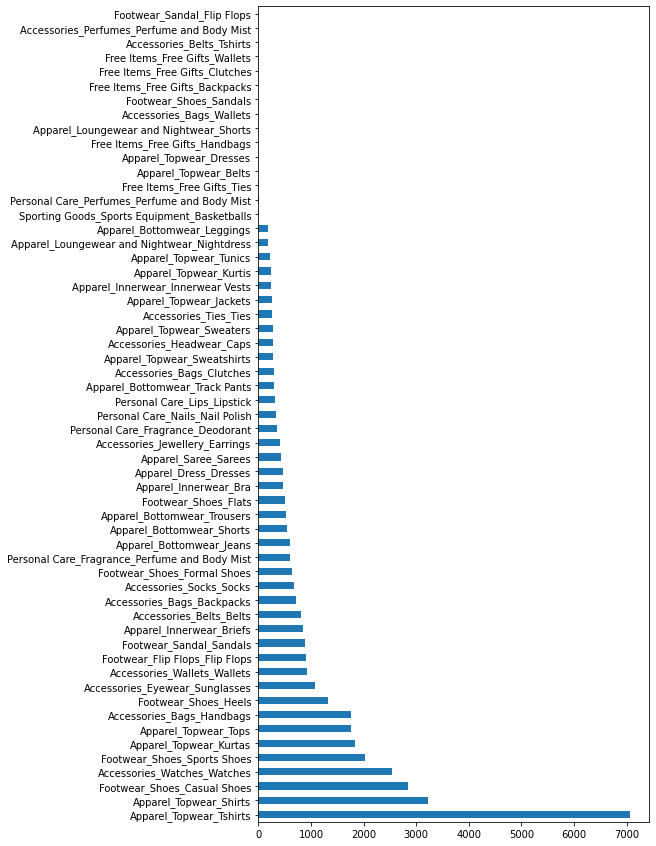

In [0]:
import matplotlib.pyplot as plt 
plt.rcParams['figure.figsize'] = [7,15]
data_labels['category'].value_counts().plot(kind='barh')
plt.savefig('drive/My Drive/labels1.jpg', bbox_inches = "tight")

In [0]:
# Then clean up the data classes so that training and test data have all classes and smaller categories are merged together.
data_labels.loc[data_labels['category'] == 'Accessories_Bags_Wallets', 'category'] = 'Accessories_Wallets_Wallets'
data_labels.loc[data_labels['category'] == 'Accessories_Belts_Tshirts', 'category'] = 'Accessories_Belts_Belts'
data_labels.loc[data_labels['category'] == 'Personal Care_Perfumes_Perfume and Body Mist', 'category'] = 'Personal Care_Fragrance_Perfume and Body Mist'
data_labels.loc[data_labels['category'] == 'Accessories_Perfumes_Perfume and Body Mist', 'category'] = 'Personal Care_Fragrance_Perfume and Body Mist'
data_labels.loc[data_labels['category'] == 'Apparel_Topwear_Dresses', 'category'] = 'Apparel_Dress_Dresses'
data_labels.loc[data_labels['category'] == 'Footwear_Sandal_Flip Flops', 'category'] = 'Footwear_Flip Flops_Flip Flops'
data_labels.loc[data_labels['category'] == 'Free Items_Free Gifts_Backpacks', 'category'] = 'Accessories_Bags_Backpacks'
data_labels.loc[data_labels['category'] == 'Free Items_Free Gifts_Handbags', 'category'] = 'Accessories_Bags_Handbags'
data_labels.loc[data_labels['category'] == 'Free Items_Free Gifts_Ties', 'category'] = 'Accessories_Ties_Ties'
data_labels.loc[data_labels['category'] == 'Free Items_Free Gifts_Wallets', 'category'] = 'Accessories_Wallets_Wallets'
data_labels.loc[data_labels['category'] == 'Free Items_Free Gifts_Clutches', 'category'] = 'Accessories_Bags_Clutches'
data_labels.loc[data_labels['category'] == 'Apparel_Loungewear and Nightwear_Shorts', 'category'] = 'Apparel_Bottomwear_Shorts'
data_labels.loc[data_labels['category'] == 'Apparel_Topwear_Belts', 'category'] = 'Accessories_Belts_Belts'
data_labels.loc[data_labels['category'] == 'Footwear_Shoes_Sandals', 'category'] = 'Footwear_Sandal_Sandals'

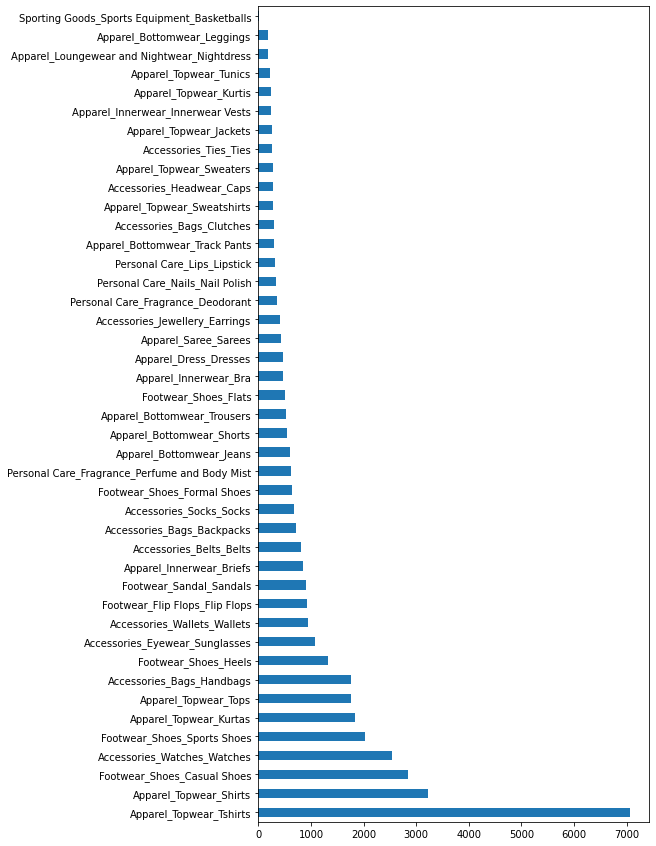

In [0]:
data_labels['category'].value_counts().plot(kind='barh')
plt.savefig('drive/My Drive/labels2.jpg', bbox_inches = "tight")

The directory structure for the fashion images has a directory for **training** and one for **test**.  To determine the class of each file, the function below reads all files in a directory and joins to the data_labels dataframe to map a file to its class.

In [0]:
def get_filenames(path, data_labels):
   file_list = os.listdir(path)
   fl = pd.DataFrame(file_list)
   fl.columns = ['filename'] 
   fl['id'], fl['filetype'] = fl['filename'].str.split('.').str # Split the filename (12345.jpg into its id (12345) and filetype (jpg)
   fl['id'] = fl['id'].astype(np.int64)

   # Join the file list to the data labels based on id columns
   labels = pd.merge(data_labels, fl, on='id')
    
   return labels

In [9]:
labels_train = get_filenames(dataset_train_dir, data_labels)   # Get training classes to files mapping
labels_test = get_filenames(dataset_test_dir, data_labels)     # Get test classes to files mapping

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  """


Function to be utllised in Part 4 and in evaluating the final model.  This will combine more groups together, reducing the classes to 40.

In [0]:
def extra_categorisation(data_labels):
  
   data_labels.loc[data_labels['category'] == 'Apparel_Topwear_Kurtis', 'category'] = 'Apparel_Topwear_Kurtas'
   data_labels.loc[data_labels['category'] == 'Footwear_Shoes_Casual Shoes', 'category'] = 'Footwear_Shoes_Casual and Sports Shoes'
   data_labels.loc[data_labels['category'] == 'Footwear_Shoes_Sports Shoes', 'category'] = 'Footwear_Shoes_Casual and Sports Shoes'
   data_labels.loc[data_labels['category'] == 'Apparel_Topwear_Tops', 'category'] = 'Apparel_Topwear_Tops and Tshirts'
   data_labels.loc[data_labels['category'] == 'Apparel_Topwear_Tshirts', 'category'] = 'Apparel_Topwear_Tops and Tshirts'

   return data_labels

# Part 2 - Convolutional Model

## Define the Image Generators

Now that the Training and Test details are in 2 dataframes, an ImageDataGenerator can be used to read the images based on a dataframe.  For training, 20% of the data will be used as a validation set.  

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_img_gen = ImageDataGenerator(rescale=1./255,validation_split=0.20)
test_img_gen = ImageDataGenerator(rescale=1./255)

In [0]:
batch_size = 128
# Split Training into Training and Validation
train_generator=train_img_gen.flow_from_dataframe(labels_train, directory=dataset_train_dir,
                                                  x_col='filename', y_col='category',
                                                  subset='training',
                                                  target_size=(80,60), color_mode='rgb', 
                                                  class_mode='categorical', batch_size=batch_size)
valid_generator=train_img_gen.flow_from_dataframe(labels_train, directory=dataset_train_dir,
                                                  x_col='filename', y_col='category',
                                                  subset='validation',
                                                  target_size=(80,60), color_mode='rgb',
                                                 class_mode='categorical', batch_size=batch_size)

# Hold Out Test set
test_generator=test_img_gen.flow_from_dataframe(labels_test, directory=dataset_test_dir,
                                                x_col='filename', y_col='category',
                                                target_size=(80,60), color_mode='rgb',shuffle=False, # Set shuffle to False on the Test set so that predictions can be mapped back to actuals
                                                class_mode='categorical', batch_size=batch_size)


Found 23998 validated image filenames belonging to 43 classes.
Found 5999 validated image filenames belonging to 43 classes.
Found 10549 validated image filenames belonging to 43 classes.


## Build the Base Model
The base model will consist of:
- Convolution Layer
- Max Pooling Layer
- Flatten Layer
- Fully Connected Layer with maxnorm regularization
- Final Softmax Output Layer of 43 classes

Various regularisation techniques were tried such as:
- Without any regularization, accuracy was approximately 82.5%
- Data Augmentation of zooming and offsetting images tended to slow the learning needing more epochs and resulted in accuracy of about 80% only
- Batch normalization again did not best the base model having an accuracy of 81.8%
- Maxnorm regularization improved performance slightly to about 83.7%

In [0]:
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization
from tensorflow.keras.constraints import max_norm

number_classes = len(train_generator.class_indices)
tf.random.set_seed(168)
np.random.seed(168)

In [0]:
model = tf.keras.Sequential()

model.add(Conv2D(128, (3,3), padding='same', activation='relu', input_shape=(80,60,3)))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(1024, activation='relu', kernel_constraint=max_norm(2.)))

model.add(Dense(number_classes, activation='softmax'))

Processing uses Adam optimization with a learning rate of 0.0001.  The loss function is categorical crossentropy as this is a multi-class classification and the metric to measure by is accuracy.

In [0]:
optimizer = tf.keras.optimizers.Adam(0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 80, 60, 128)       3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 30, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 153600)            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              157287424 
_________________________________________________________________
dense_1 (Dense)              (None, 43)                44075     
Total params: 157,335,083
Trainable params: 157,335,083
Non-trainable params: 0
_________________________________________________________________


## Train the Model

Here the model is trained for 30 epochs which gives an accuracy of approximately 83.7%.

In [0]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
history = model.fit_generator(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    epochs=30,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
187/187 [==============================] - 15s 81ms/step - loss: 2.1195 - accuracy: 0.4740 - val_loss: 1.2866 - val_accuracy: 0.6484
Epoch 2/30
187/187 [==============================] - 14s 77ms/step - loss: 1.0462 - accuracy: 0.7113 - val_loss: 0.9471 - val_accuracy: 0.7379
Epoch 3/30
187/187 [==============================] - 15s 78ms/step - loss: 0.8620 - accuracy: 0.7535 - val_loss: 0.8686 - val_accuracy: 0.7546
Epoch 4/30
187/187 [==============================] - 15s 78ms/step - loss: 0.7734 - accuracy: 0.7756 - val_loss: 0.8077 - val_accuracy: 0.7619
Epoch 5/30
187/187 [==============================] - 15s 78ms/step - loss: 0.7187 - accuracy: 0.7922 - val_loss: 0.7591 - val_accuracy: 0.7648
Epoch 6/30
187/187 [==============================] - 15s 78ms/step - loss: 0.6655 - accuracy: 0.8070 - val_loss: 0.7529 - val_accuracy: 0.7814
Epoch 7/30
187/187 [==============================] - 15s 78

Plot the training versus validation accuracy per epoch.

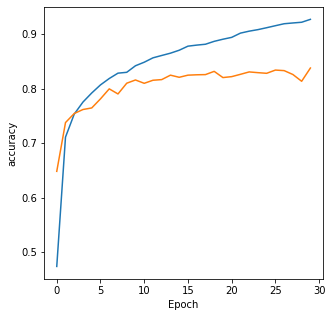

In [0]:
import matplotlib.pyplot as plt 

plt.rcParams['figure.figsize'] = [5, 5]
plt.plot(history.history['accuracy'], label='training')
plt.plot(history.history['val_accuracy'], label='validation')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.show()

### Testing on Unseen data
Now, the model is tested on the held out test set to see how unseen data performs.  The predictions for each test file are also created, to be displayed in a confusion matrix.

In [0]:
model.evaluate_generator(generator=test_generator,
steps=STEP_SIZE_TEST)

Instructions for updating:
Please use Model.evaluate, which supports generators.


[0.5227579474449158, 0.8367949724197388]

In [0]:

test_generator=test_img_gen.flow_from_dataframe(labels_test, directory=dataset_test_dir,
                                                x_col='filename', y_col='category',
                                                target_size=(80,60), color_mode='rgb',shuffle=False, # Set shuffle to False on the Test set so that predictions can be mapped back to actuals
                                                class_mode='categorical', batch_size=batch_size)
pred=model.predict_generator(test_generator,
steps=STEP_SIZE_TEST+1,   # Add 1 to ensure all images are predicted on
verbose=1)

Found 10549 validated image filenames belonging to 43 classes.
Instructions for updating:
Please use Model.predict, which supports generators.
83/83 [==============================] - 4s 49ms/step


### Confusion Matrix of Predictions
The graph below shows how the test set performed of Actuals versus Predictions.  Mostly the model performs well, misclassifying items that are close to each other such as tops and t-shirts or trousers and jeans.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


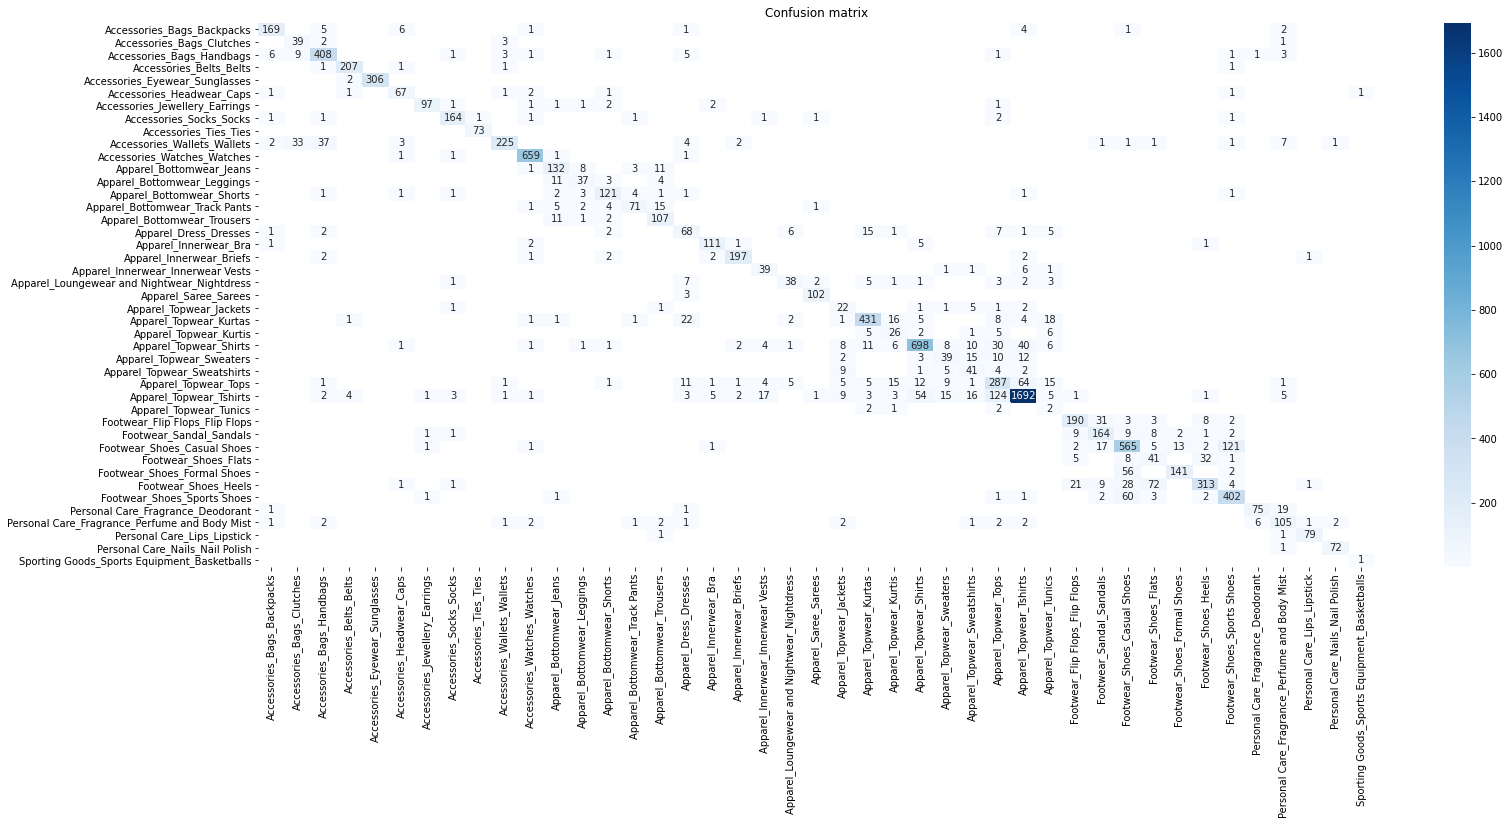

In [0]:
import matplotlib
import seaborn as sns

pred_test = np.argmax(pred, 1)
labels_test['mapping'] = labels_test['category'].map(test_generator.class_indices)
confusion_mat = tf.math.confusion_matrix(pred_test,labels_test['mapping'], num_classes=number_classes)
cm=pd.DataFrame(confusion_mat.numpy())
target_names = test_generator.class_indices.keys()


cm[cm == 0] = np.nan  # Do not display 0's to make the display cleaner
plt.rcParams['figure.figsize'] = [25, 10]
ax = sns.heatmap(cm, annot=True, yticklabels=target_names, xticklabels=target_names, cmap='Blues', fmt='g')

plt.title('Confusion matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
    
plt.savefig('drive/My Drive/cm_part1.jpg', bbox_inches = "tight")
plt.show()

# Part 3 - Transfer Learning

Here, transfer learning from a pre-built model is used to apply to the problem at hand.  The steps to do are:
- Download a model trained on the imagenet database and exclude the final layer (as it classifies 1,000 images)
- Freeze all layers so that the pre-trained weights are applied.
- Add the output layer for this classification
- Train on the training dataset again and evaluate

## Image Data Generator
As for the base model, image data generators are used for reading the images.

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_img_gen = ImageDataGenerator(rescale=1./255,validation_split=0.20)
test_img_gen = ImageDataGenerator(rescale=1./255)

In [0]:
# Split Training into Train and Validate
train_generator=train_img_gen.flow_from_dataframe(labels_train, directory=dataset_train_dir,
                                                  x_col='filename', y_col='category',
                                                  subset='training',
                                                  target_size=(280, 210), color_mode='rgb', 
                                                  class_mode='categorical', batch_size=128)
valid_generator=train_img_gen.flow_from_dataframe(labels_train, directory=dataset_train_dir,
                                                  x_col='filename', y_col='category',
                                                  subset='validation',
                                                  target_size=(280, 210), color_mode='rgb',
                                                 class_mode='categorical', batch_size=128)

# Hold Out Test set
test_generator=test_img_gen.flow_from_dataframe(labels_test, directory=dataset_test_dir,
                                                  x_col='filename', y_col='category',
                                                  target_size=(280, 210), color_mode='rgb',shuffle=False,
                                                 class_mode='categorical', batch_size=128)

Found 23998 validated image filenames belonging to 43 classes.
Found 5999 validated image filenames belonging to 43 classes.
Found 10549 validated image filenames belonging to 43 classes.


## Pre-Built Models Download

A base model to use is downloaded.  Models tried here were:
- MobileNetV2
- InceptionV3
- VGG19
- Xception
- Resnet152V2

Densenet201 was utilised in the final output.

In [0]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Dense, Flatten
number_classes = len(train_generator.class_indices)

# Create the base model from the pre-trained model MobileNet V2
#base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
#                                               include_top=False,
#                                               weights='imagenet')
#base_model = tf.keras.applications.InceptionV3(    include_top=False, weights='imagenet', input_shape=(120, 90 , 3))
#base_model = tf.keras.applications.VGG19(    include_top=False, weights='imagenet', input_shape=(80, 60 , 3))
#base_model = tf.keras.applications.Xception(    include_top=False, weights='imagenet', input_shape=(120, 90 , 3))
#base_model = tf.keras.applications.ResNet152V2(    include_top=False, weights='imagenet', input_shape=(200, 200 , 3))
base_model = tf.keras.applications.DenseNet201(    include_top=False, weights='imagenet', input_shape=(280, 210 , 3))

74842112/74836368 [==============================] - 0s 0us/step


The base model downloaded is then frozen and a new prediction layer added to it.  Then the model is compiled, ready to be fitted.

In [0]:
base_model.trainable = False

In [0]:
prediction_layer = Dense(number_classes, activation='softmax')
flat_layer = Flatten()

model = tf.keras.Sequential([
  base_model,
  flat_layer,
  prediction_layer
])

In [0]:
optimizer = tf.keras.optimizers.Adam(0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 8, 6, 1920)        18321984  
_________________________________________________________________
flatten_1 (Flatten)          (None, 92160)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 43)                3962923   
Total params: 22,284,907
Trainable params: 3,962,923
Non-trainable params: 18,321,984
_________________________________________________________________


Now the model is trained on our dataset.  The data was again split into 80% training and 20% validation.

In [0]:

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
history = model.fit_generator(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN+1,
    epochs=10,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID+1
)

Epoch 1/10
188/188 [==============================] - 87s 462ms/step - loss: 0.6032 - accuracy: 0.8154 - val_loss: 0.4094 - val_accuracy: 0.8668
Epoch 2/10
188/188 [==============================] - 80s 427ms/step - loss: 0.2449 - accuracy: 0.9163 - val_loss: 0.4110 - val_accuracy: 0.8685
Epoch 3/10
188/188 [==============================] - 80s 427ms/step - loss: 0.1519 - accuracy: 0.9481 - val_loss: 0.3831 - val_accuracy: 0.8743
Epoch 4/10
188/188 [==============================] - 80s 425ms/step - loss: 0.1064 - accuracy: 0.9661 - val_loss: 0.3703 - val_accuracy: 0.8826
Epoch 5/10
188/188 [==============================] - 80s 426ms/step - loss: 0.0791 - accuracy: 0.9760 - val_loss: 0.3723 - val_accuracy: 0.8840
Epoch 6/10
188/188 [==============================] - 80s 426ms/step - loss: 0.0566 - accuracy: 0.9859 - val_loss: 0.3599 - val_accuracy: 0.8898
Epoch 7/10
188/188 [==============================] - 80s 427ms/step - loss: 0.0460 - accuracy: 0.9888 - val_loss: 0.3627 - val_ac

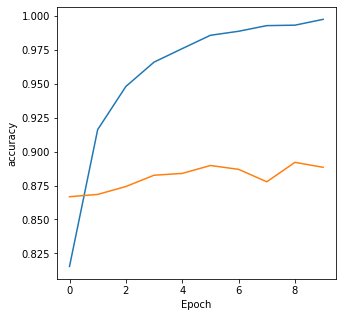

In [0]:
import matplotlib.pyplot as plt 

plt.rcParams['figure.figsize'] = [5, 5]
plt.plot(history.history['accuracy'], label='training')
plt.plot(history.history['val_accuracy'], label='validation')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.show()

## Evaluate and Predict on Test set

After building the model, the held-out test set is then evaluated and predicted on, to compare to actuals.

In [0]:
model.evaluate_generator(generator=test_generator,
steps=STEP_SIZE_TEST+1)

[0.3515448272228241, 0.8947767615318298]

In [0]:
pred=model.predict_generator(test_generator,
steps=STEP_SIZE_TEST+1,   # Add 1 to ensure all images are predicted on
verbose=1)

83/83 [==============================] - 28s 334ms/step


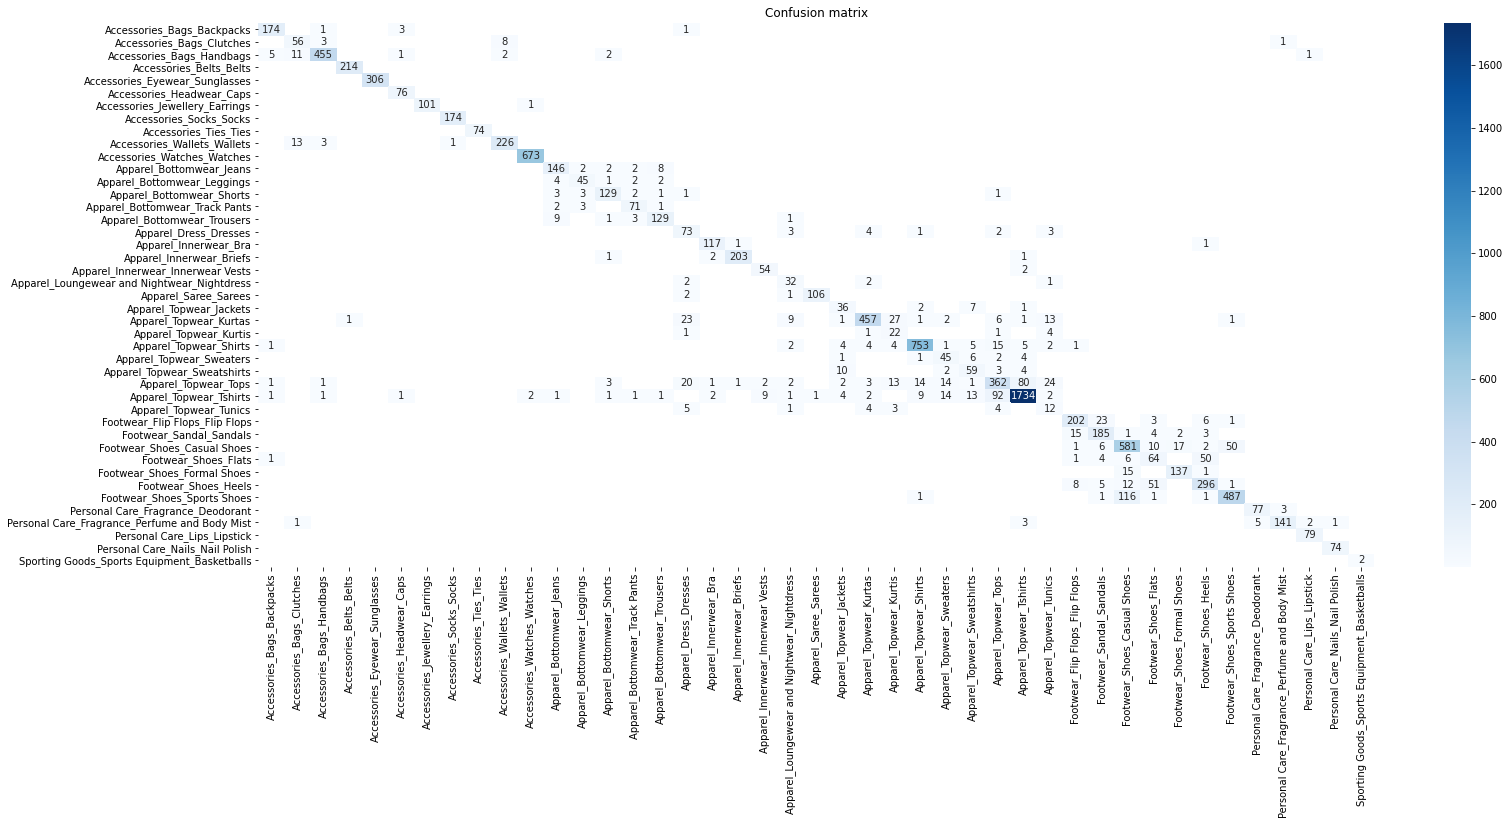

In [0]:
import matplotlib
import seaborn as sns

pred_test = np.argmax(pred, 1)
labels_test['mapping'] = labels_test['category'].map(test_generator.class_indices)
confusion_mat = tf.math.confusion_matrix(pred_test,labels_test['mapping'], num_classes=number_classes)
cm=pd.DataFrame(confusion_mat.numpy())
target_names = test_generator.class_indices.keys()


cm[cm == 0] = np.nan  # Do not display 0's to make the display cleaner
plt.rcParams['figure.figsize'] = [25, 10]
ax = sns.heatmap(cm, annot=True, yticklabels=target_names, xticklabels=target_names, cmap='Blues', fmt='g')

plt.title('Confusion matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
    
plt.savefig('drive/My Drive/cm_part2.jpg', bbox_inches = "tight")
plt.show()

# Part 4 - Improving the Model
This section will attempt to improve on the work done above to improve accuracy.  A pre-trained model will agaib be used, as it's initial accuracy was a good improvement on the bespoke model.

Densenet 201 will be used, as above it showed a small improvement over pre-trained models.

Various configurations were tried with:

- Keeping all layers frozen and adding convolution and fully connected layers after the base model
- Lowering the learning rate to 0.00001
- Unfreezing layers at the end of the pre-built model
- Utilising dropout

Categories are cleaned a little more here, combining categories that are the same to make the model more generalised (eg, kurtas and kurtis are essentially the same, and tops and t-shirts are hard to distinguish from one another so a combined class of Tops and T-Shirts has been created).


In [0]:
data_labels = extra_categorisation(data_labels)
labels_train = get_filenames(dataset_train_dir, data_labels)   # Get training classes to files mapping
labels_test = get_filenames(dataset_test_dir, data_labels)     # Get test classes to files mapping

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  """


## Data Augmentation
To allow the model to train on 'more' images, data augmentation has been added to:
- Shift images from the centre of the photo
- magnify images
- shear photos
This should again improve the generalisation of the model and prepare for images loaded by the general public.

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_img_gen = ImageDataGenerator(rescale=1./255,validation_split=0.20, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.2,zoom_range=0.2, fill_mode='nearest')
test_img_gen = ImageDataGenerator(rescale=1./255)

In [0]:
# Split Training into Train and Validate
train_generator=train_img_gen.flow_from_dataframe(labels_train, directory=dataset_train_dir,
                                                  x_col='filename', y_col='category',
                                                  subset='training',
                                                  target_size=(280, 210), color_mode='rgb', 
                                                  class_mode='categorical', batch_size=32)
valid_generator=train_img_gen.flow_from_dataframe(labels_train, directory=dataset_train_dir,
                                                  x_col='filename', y_col='category',
                                                  subset='validation',
                                                  target_size=(280, 210), color_mode='rgb',
                                                 class_mode='categorical', batch_size=32)


number_classes = len(train_generator.class_indices)

Found 23998 validated image filenames belonging to 40 classes.
Found 5999 validated image filenames belonging to 40 classes.


## Load Densenet Model

The Densenet 201 model is used as the basis of the model.  It is a very complicated structure with over 700 layers.  It has been tailored to this dataset by:
- Unfreezing all layers as the Densenet architecture allows layers to access all previous layers.
- Adding a Fully Connected layer to pick up nuances of the specific images we are dealing with 
- The final prediction layer with 38 classes to define.

The Adam optimizer is used to optimize with a learning rate of 0.0001.

In [0]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.constraints import max_norm

base_model_3 = tf.keras.applications.DenseNet201(include_top=False, weights='imagenet', input_shape=(280, 210 , 3))

In [0]:
prediction_layer = Dense(number_classes, activation='softmax')
flat_layer = Flatten()

model = tf.keras.Sequential([
  base_model_3,
  flat_layer,
  Dense(512, activation='relu', kernel_constraint=max_norm(2.)),
  prediction_layer
])

In [0]:
optimizer = tf.keras.optimizers.Adam(0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 8, 6, 1920)        18321984  
_________________________________________________________________
flatten_2 (Flatten)          (None, 92160)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               47186432  
_________________________________________________________________
dense_3 (Dense)              (None, 40)                20520     
Total params: 65,528,936
Trainable params: 65,299,880
Non-trainable params: 229,056
_________________________________________________________________


## Training The Model
The model is then trained for 10 epochs and the training versus validation accuracy is shown below.  There appears to be some overfitting but not too extreme.

In [0]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
history = model.fit_generator(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN+1,
    epochs=20,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID+1
)

Epoch 1/20
750/750 [==============================] - 447s 596ms/step - loss: 0.5425 - accuracy: 0.8497 - val_loss: 0.3343 - val_accuracy: 0.8960
Epoch 2/20
750/750 [==============================] - 441s 589ms/step - loss: 0.2792 - accuracy: 0.9110 - val_loss: 0.3403 - val_accuracy: 0.9008
Epoch 3/20
750/750 [==============================] - 452s 603ms/step - loss: 0.2113 - accuracy: 0.9307 - val_loss: 0.3150 - val_accuracy: 0.8996
Epoch 4/20
750/750 [==============================] - 464s 618ms/step - loss: 0.1746 - accuracy: 0.9397 - val_loss: 0.4034 - val_accuracy: 0.8971
Epoch 5/20
750/750 [==============================] - 467s 623ms/step - loss: 0.1572 - accuracy: 0.9460 - val_loss: 0.3098 - val_accuracy: 0.9152
Epoch 6/20
750/750 [==============================] - 464s 619ms/step - loss: 0.1641 - accuracy: 0.9460 - val_loss: 0.3183 - val_accuracy: 0.9108
Epoch 7/20
750/750 [==============================] - 467s 622ms/step - loss: 0.1390 - accuracy: 0.9542 - val_loss: 0.3046 -

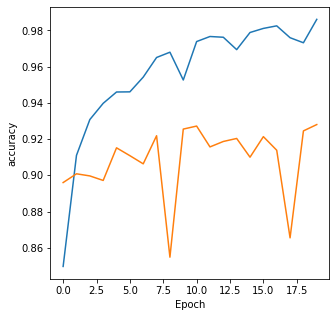

In [0]:
import matplotlib.pyplot as plt 

plt.rcParams['figure.figsize'] = [5, 5]
plt.plot(history.history['accuracy'], label='training')
plt.plot(history.history['val_accuracy'], label='validation')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.savefig('drive/My Drive/Epoch3.jpg', bbox_inches = "tight")
plt.show()

## Save The Model
The model is then saved, to be able to be reloaded later and utilised in evaluation nd prediction.

In [0]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('drive/My Drive/88451999_AT1B.h5') 

# Part 5 - Load and Utilise The Saved Model
The model built in Part 4 was saved to **My Drive** in Google drive and is then reloaded here. To utilise the model on the saved data, the following should be done:
- Run Part 1 of this notebook to mount the google drive and read in the zipped file and transform the data labels.
- Then continue on running each step below.  This will load the model, setup the data labels for testing to match the trained model and then evaluate and predict on the test data.

In [11]:
# Recreate the exact same model, including its weights and the optimizer
load_model = tf.keras.models.load_model('drive/My Drive/88451999_AT1B.h5')

# Show the model architecture
load_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 8, 6, 1920)        18321984  
_________________________________________________________________
flatten_2 (Flatten)          (None, 92160)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               47186432  
_________________________________________________________________
dense_3 (Dense)              (None, 40)                20520     
Total params: 65,528,936
Trainable params: 65,299,880
Non-trainable params: 229,056
_________________________________________________________________


Amalgammate categories to make model more generalised.

In [12]:
data_labels = extra_categorisation(data_labels)
labels_train = get_filenames(dataset_train_dir, data_labels)   # Get training classes to files mapping
labels_test = get_filenames(dataset_test_dir, data_labels)     # Get test classes to files mapping

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  """


Set up Image Data Generator for Test set and then evaluate and predict.

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_img_gen = ImageDataGenerator(rescale=1./255)

# Hold Out Test set
test_generator=test_img_gen.flow_from_dataframe(labels_test, directory=dataset_test_dir,
                                                  x_col='filename', y_col='category',
                                                  target_size=(280, 210), color_mode='rgb',shuffle=False,  # Ensure testing is the same order to compare predictions to actuals.
                                                 class_mode='categorical', batch_size=128)
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
number_classes = len(test_generator.class_indices)

Found 10549 validated image filenames belonging to 40 classes.


In [14]:
load_model.evaluate_generator(generator=test_generator,
steps=STEP_SIZE_TEST+1)

Instructions for updating:
Please use Model.evaluate, which supports generators.


[0.3367627263069153, 0.9313678741455078]

In [15]:
pred=load_model.predict_generator(test_generator,
steps=STEP_SIZE_TEST+1,   # Add 1 to ensure all images are predicted on
verbose=1)

Instructions for updating:
Please use Model.predict, which supports generators.
83/83 [==============================] - 54s 655ms/step


## Model Performance
A Confusion Matrix is created of Predictions versus Actual.  The percentage of correctly classified images by category is also created to explore which categories are performing well or poorly.

Insights:
- The model tends to classify correctly within sub-categories so displays good grouping of topwear, bottomwear, shoes and accessories. 
- Tunics (approximately 20% accuracy) is the worst performing category, either misclassified as Kurtas, dresses or Tops and T-Shirts.  The images classified as tunics are often very similar to those groups so is hard to identify correctly.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


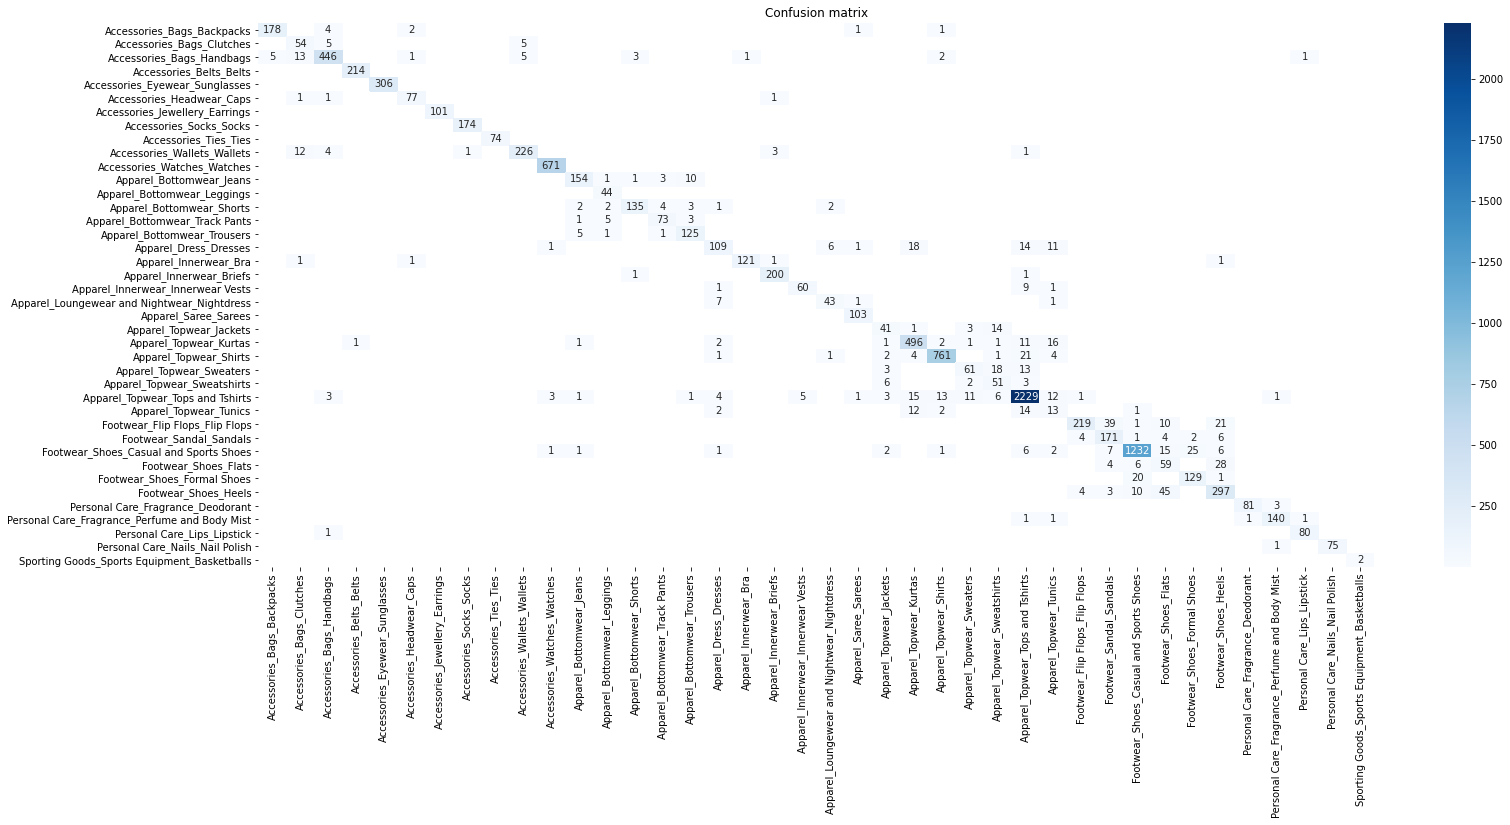

In [16]:
import matplotlib.pyplot as plt 
import seaborn as sns

pred_test = np.argmax(pred, 1)
labels_test['mapping'] = labels_test['category'].map(test_generator.class_indices)
confusion_mat = tf.math.confusion_matrix(pred_test,labels_test['mapping'], num_classes=number_classes)
cm=pd.DataFrame(confusion_mat.numpy())
target_names = test_generator.class_indices.keys()

cm[cm == 0] = np.nan  # Do not display 0's to make the display cleaner
plt.rcParams['figure.figsize'] = [25, 10]
ax = sns.heatmap(cm, annot=True, yticklabels=target_names, xticklabels=target_names, cmap='Blues', fmt='g')

plt.title('Confusion matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
    
plt.savefig('drive/My Drive/cm_part3.jpg', bbox_inches = "tight")
plt.show()

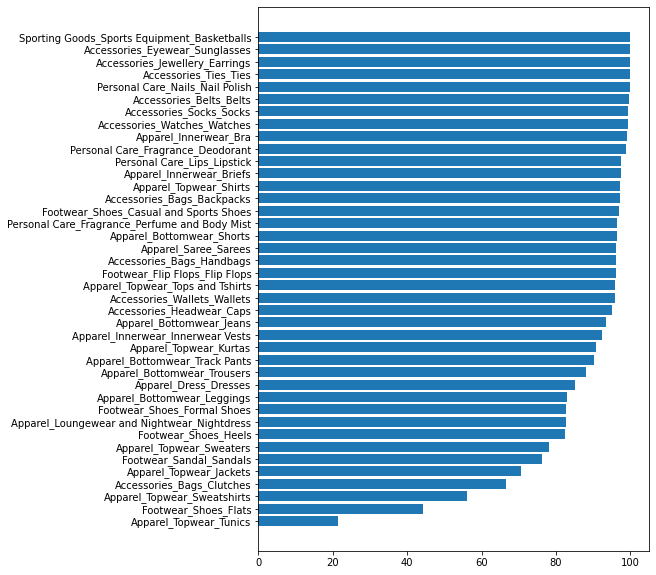

In [17]:
labels_test['prediction'] = pred_test
labels_test['match'] = np.where(labels_test.mapping == labels_test.prediction, 1, 0)
pct = round((labels_test.groupby(['category'])['match'].sum() / labels_test.groupby(['category'])['match'].count()) * 100, 2)
pct = pct.reset_index()
pct.columns = ['category', 'correct'] 
pct = pct.sort_values('correct')
plt.figure(figsize=(7, 10))

plt.barh(pct.category, pct.correct, align='center')
plt.savefig('drive/My Drive/percents.jpg', bbox_inches = "tight")
plt.show()

Display percentages correct per category.

In [18]:
pct

,category,correct
28,Apparel_Topwear_Tunics,21.31
32,Footwear_Shoes_Flats,44.36
26,Apparel_Topwear_Sweatshirts,56.04
1,Accessories_Bags_Clutches,66.67
22,Apparel_Topwear_Jackets,70.69
30,Footwear_Sandal_Sandals,76.34
25,Apparel_Topwear_Sweaters,78.21
34,Footwear_Shoes_Heels,82.50
20,Apparel_Loungewear and Nightwear_Nightdress,82.69
33,Footwear_Shoes_Formal Shoes,82.69
